import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [1]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import pandas
import geopandas as gpd
from shapely.geometry import shape, Point
import fiona
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [2]:
arena_df = pd.read_csv("data/arenas_w_locations.csv", index_col=0)
arena_gdf = gpd.GeoDataFrame(
            arena_df, geometry=gpd.points_from_xy(arena_df.Lng, arena_df.Lat))
us_can_gdf = gpd.read_file("data/full_us_can_geometry.geojson")

## Data Engineering

In [3]:
# just arena coords
arena_coords = arena_df[['Team_name', 'Lat', 'Lng']]

# Clustergram

K=1 fitted in 0.7698299884796143 seconds.
K=2 fitted in 1.336742877960205 seconds.
K=3 fitted in 1.5707833766937256 seconds.
K=4 fitted in 1.9638879299163818 seconds.
K=5 fitted in 2.1643600463867188 seconds.
K=6 fitted in 2.395801305770874 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

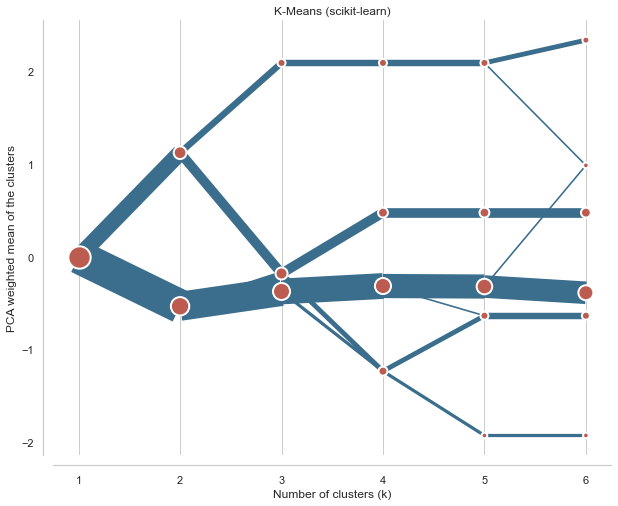

In [4]:
# from the clustergram project page 
data = scale(arena_coords.drop(columns=['Team_name']))

cgram = Clustergram(range(1, 7), n_init=1000)
cgram.fit(data)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

## Analyzing the optimal number of clusters

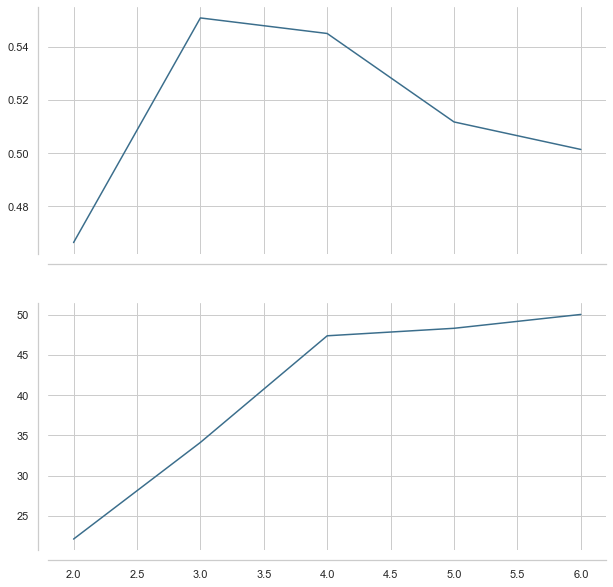

In [5]:
# also from the project page 
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
# score of 1 is best with the silhouette score
cgram.silhouette_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
# the higher the value, the better
cgram.calinski_harabasz_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

**3 or 4 clusters looks optimal**. Therefore, when we use a clustering algorithm (e.g.: Kmeans), we know the number of clusters for it to create.

# Cluster the data - Kmeans

## With 3 Clusters

In [6]:
# adjusting the data to be an array
X = np.array(arena_coords[['Lat', 'Lng']])

In [7]:
# applying Kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [8]:
# adding labels to player_gdf
arena_gdf['arena_cluster'] = kmeans.labels_

In [9]:
kmeans.cluster_centers_

array([[  39.58365   ,  -77.51950625],
       [  40.93657778, -115.68338889],
       [  40.71575   ,  -91.95156667]])

# Plotting Data

<AxesSubplot:>

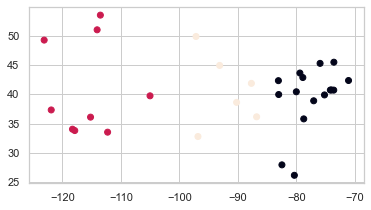

In [10]:
arena_gdf.plot(column='arena_cluster')

## Adding Centroids to the data

In [11]:
centroid_gdf = gpd.GeoDataFrame(data=[f"Cluster{x}" for x in range(0, 3)], columns = ['Team_name'])

In [12]:
# making the centroids into points
centroid_gdf['geometry'] = [Point(coord[1], coord[0]) for coord in kmeans.cluster_centers_]
centroid_gdf['arena_cluster'] = [x for x in range(4, 7)]

In [13]:
# cluster0's centroid is near Rochester, NY, USA
# cluster1's centroid is near the northern Washington/Idaho border, USA
# cluster2's centroid is west of Minneapolis, MN, USA
centroid_gdf

,Team_name,geometry,arena_cluster
0,Cluster0,POINT (-77.51951 39.58365),4
1,Cluster1,POINT (-115.68339 40.93658),5
2,Cluster2,POINT (-91.95157 40.71575),6


In [14]:
# merging the two
arena_gdf_w_centroids = pd.concat([arena_gdf, centroid_gdf])
# player_gdf.concat(centroid_gdf)

<AxesSubplot:>

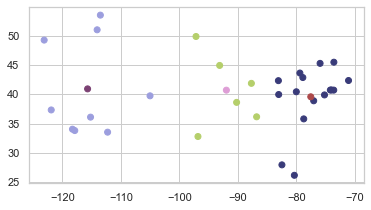

In [15]:
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
arena_gdf_w_centroids.plot(column='arena_cluster', cmap='tab20b')
# plt.savefig("pictures/player_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

<AxesSubplot:>

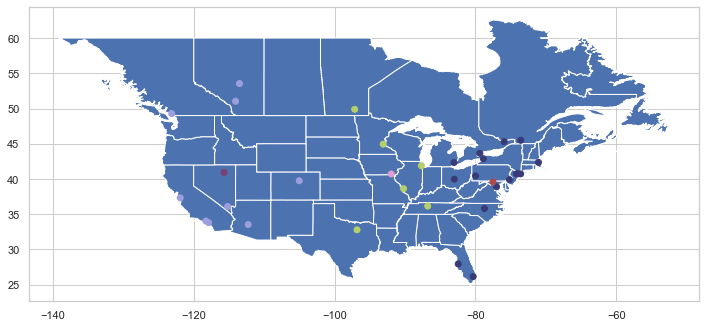

In [20]:
ax1 = us_can_gdf.plot(figsize = (12, 12))
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
arena_gdf_w_centroids.plot(column='arena_cluster', cmap='tab20b', ax=ax1, figsize = (12, 12))
# plt.savefig("pictures/arena_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

## How many arenas are in each cluster?

In [17]:
# clusters: 0 = east coast, 1 = west coast, 2 = central
# more teams in east coast than west and central (least)
arena_gdf.arena_cluster.value_counts()

0    16
1     9
2     6
Name: arena_cluster, dtype: int64

In [21]:
arena_gdf

,Team_name,Arena_name,Coordinates,Canadian_team,Lat,Lng,geometry,arena_cluster
0,New Jersey Devils,Prudential Center,"40.7336,-74.1711",False,40.7336,-74.1711,POINT (-74.17110 40.73360),0
1,New York Islanders,Nassau Veterans Memorial Coliseum,"40.7233,-73.5907",False,40.7233,-73.5907,POINT (-73.59070 40.72330),0
2,New York Rangers,Madison Square Garden,"40.7506,-73.9936",False,40.7506,-73.9936,POINT (-73.99360 40.75060),0
3,Philadelphia Flyers,Wells Fargo Center,"39.9011,-75.1719",False,39.9011,-75.1719,POINT (-75.17190 39.90110),0
4,Pittsburgh Penguins,PPG Paints Arena,"40.4394,-79.9892",False,40.4394,-79.9892,POINT (-79.98920 40.43940),0
5,Boston Bruins,TD Garden,"42.3662,-71.0621",False,42.3662,-71.0621,POINT (-71.06210 42.36620),0
6,Buffalo Sabres,KeyBank Center,"42.875,-78.8764",False,42.8750,-78.8764,POINT (-78.87640 42.87500),0
7,Montréal Canadiens,Bell Centre,"45.4961,-73.5694",True,45.4961,-73.5694,POINT (-73.56940 45.49610),0
8,Ottawa Senators,Canadian Tire Centre,"45.2969,-75.9272",True,45.2969,-75.9272,POINT (-75.92720 45.29690),0
9,Toronto Maple Leafs,Scotiabank Arena,"43.6433,-79.3792",True,43.6433,-79.3792,POINT (-79.37920 43.64330),0
